In [1]:
# Some plotting imports
%matplotlib inline

# Motivation

The usual algorithms used to run wind farm flow models in order to calculate annual energy production is utilizing a lot of nested `for` loops which make them innapropriate for scripting languages such as Matlab of Python. The following code snippet illustrate a typical algorithm to calculate the AEP in python.

```python
AEP = 0.0
for ws in wind_speed_cases:
    for wd in wind_direction_cases:
        for wt in wind_turbines.sort(wd):
            wt.du[ws, wd] = []
            for wt_up in wt.upstream_wind_turbines(wd):
                wt.du[ws, wd].append(calculate_deficit(wt_up, wt, wd, ws))
            wt.ws[ws, wd] = aggregate_wake(wt.du[ws, wd])
            wt.power[ws, wd] = wt.power_curve(wt.ws[ws, wd])
            wt.ct[ws, wd] = wt.ct_curve(wt.ws[ws, wd])            
        AEP += Nt * wt.power[ws, wd] * frequency(ws, wd)
```

As it can be seen the function `calculate_deficit` is called $N_{WS} . N_{WD} . N_{WT} . (N_{WT}-1)/2 $ times. With $N_{WS}$ the number of wind speed case, $N_{WD}$ the number of wind direction case, $N_{WT}$ the number of wind turbines in the wind farm. If those numbers are large, and the time to calculate the wake wind speed deficit is significant then the total time adds up significantly. To estimate the AEP of a 100-turbine wind farm with this method can easily reach 30 million function evaluations.

In [2]:
n_executions = lambda n_ws, n_wd, n_wt: [n_ws, n_wd, n_wt, n_ws * n_wd * n_wt * (n_wt - 1)/2]
print("Number of function evaluations for N_WS={:d}, N_WD={:d} and {:d} turbines: {:2.2E}".format(
        *n_executions(n_ws=21, n_wd=360, n_wt=100)))

Number of function evaluations for N_WS=21, N_WD=360 and 100 turbines: 3.74E+07


This is particularly critical in the context of wind farm layout optimization, where the AEP of many different layouts need to be evaluated iteratively. Or in the case of an uncertainty quantification exercise, where 100,000s to millions time more wind direction and wind speed cases have to be executed.
A way to approach this is to put the `for` loops into a compiled language as fast as possible such as Fortran of C. This is done at the expense of the coding flexibility that are offered by modern scripting languages such as Python and Matlab. What we propose in this paper is to explore the potential of using vectorization to reduce the number of function evalutation and dramatically speeding up the calculation of an AEP with uncertainty propagation.

# Method

The methodology is to first make sure that the wake deficit function is vectorizable. So that it can produce a vector output according to a set of vector inputs. 

### Generating a random layout of 100 turbines

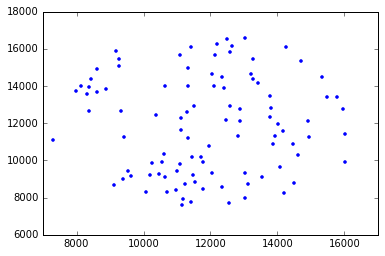

In [4]:
from waketor.lib import generate_random_coord, plot_coord
D = 80.0
coord = generate_random_coord(100, 60*D, 3*D)
plot_coord(coord)